In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Setting up data

In [2]:
# Set up data sets
from sklearn.model_selection import train_test_split

X_test_full = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')
X_full = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
X_full.dropna(axis=0, subset=['Survived'])

y = X_full.Survived
X_full.drop(['Survived'], axis=1, inplace=True)

feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
X = X_full[feature_columns]
X_test = X_test_full[feature_columns]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print('Amount of rows for training set: %d' %(X.shape[0]))

Amount of rows for training set: 891


In [3]:
X.head()

,Pclass,Sex,Age,SibSp,Parch
PassengerId,,,,,
1,3,male,22.0,1,0
2,1,female,38.0,1,0
3,3,female,26.0,0,0
4,1,female,35.0,1,0
5,3,male,35.0,0,0


## Preprocessing

In [4]:
print('Amount of missing values in each column: ')
X.isnull().sum()

Amount of missing values in each column: 


Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
dtype: int64

<font size=3>There are missing values for the Age feature. A bit of data analysis is necessary in order to fill in those empty values in a meaningful way. **Reminder: we should use the training set when deriving features from data to avoid contamination.**

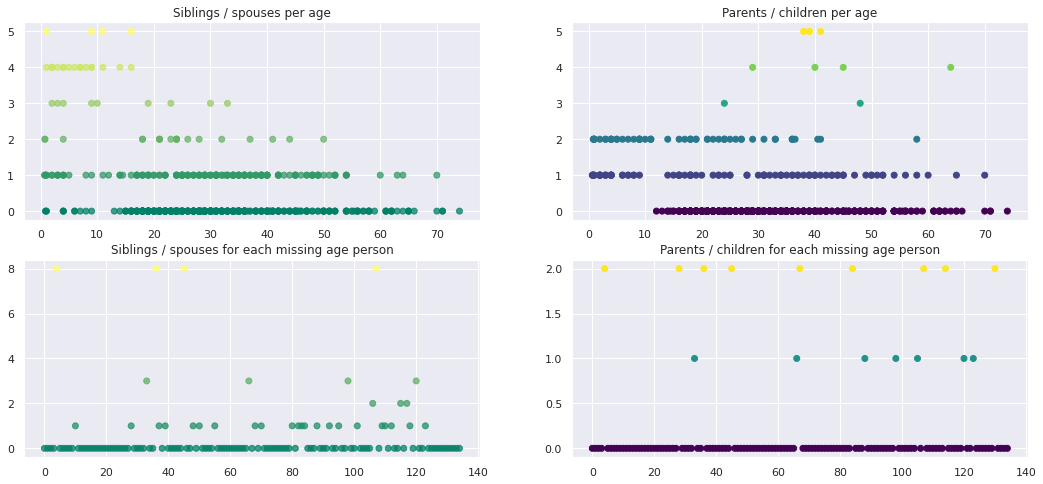

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(2, 2, figsize=(18, 8))
ax[0,0].scatter(x=X_train.Age, y=X_train.SibSp, alpha=0.75, c=X_train.SibSp,  cmap=cm.get_cmap('summer'))
ax[0,0].set_title('Siblings / spouses per age')
ax[0,1].scatter(x=X_train.Age, y=X_train.Parch, c=X_train.Parch, cmap=cm.get_cmap('viridis'))
ax[0,1].set_title('Parents / children per age')

x1 = X_train[X_train.Age.isnull()]
ax[1,0].scatter(range(len(x1)), x1.SibSp, alpha=0.75, c=x1.SibSp,  cmap=cm.get_cmap('summer'))
ax[1,0].set_title('Siblings / spouses for each missing age person')
ax[1,1].scatter(range(len(x1)), x1.Parch, c=x1.Parch, cmap=cm.get_cmap('viridis'))
ax[1,1].set_title('Parents / children for each missing age person')

plt.show()

<font size=3>The vast majority of people with missing input for the Age column have no siblings/spouses or parents/children, therefore it makes sense to use the average age within that group (people with no siblings/spouses or parents/children) as an estimation for the age values.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

avg_Age = X_train[(X_train.SibSp + X_train.Parch) == 0].Age.mean()

numerical_transformer = SimpleImputer(strategy='constant', fill_value=avg_Age)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, make_column_selector(dtype_include=[np.integer, np.floating])),
    ('cat', categorical_transformer,  make_column_selector(dtype_include=object))
])

print('Amount of missing values in each column for all data after preprocessing: ')
pd.DataFrame(preprocessor.fit_transform(X_train)).isnull().sum()

Amount of missing values in each column for all data after preprocessing: 


0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

## Hypertuning

<font size=3>Now that we have our transformers which can handle both missing and categorical data, we can use them during **cross validation** and try to find the best set of parameters for our model.
    
<font size=3>Since we are dealing with a classification problem, the **XGBoost Classifier** (eXtreme Gradient Boosting) will be chosen as the model. It works by assigning scores to each leaf as it adds trees (CARTs) to the ensemble model. Then, the trees are run based on the input parameters and scores are calculated, so they can be summed to obtain the prediction result.

<div style="width:100%; text-align:center">
<img align=middle src=https://www.researchgate.net/profile/Li-Mingtao-2/publication/335483097/figure/fig3/AS:934217085100032@1599746118459/A-general-architecture-of-XGBoost.ppm width=500px>

<font size=3>We also have to make a custom function to implement cross validation if we want to make use of XGBoost's **early_stopping_rounds**, since we need access to the validation splits during the cross validation process.

In [7]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import accuracy_score, roc_auc_score

def XGB_CVGridSearch(estimator, X, y, estimator_params, n_splits=5, verbose=0, vectorize_output=False):
    # Searches for the best combination of given parameters for estimator
    
    skf = StratifiedKFold(n_splits=n_splits)
    best_params = None
    best_score = 0
    for params_permut in ParameterGrid(estimator_params):
        val_scores = np.empty(skf.n_splits)
        train_scores = val_scores.copy()
        for i, (train_index, val_index) in enumerate(skf.split(X, y)):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_val, y_val = X.iloc[val_index], y.iloc[val_index]
            estimator.set_params(**params_permut)
            estimator.fit(X_train, y_train,
                        model__eval_set=[(preprocessor.transform(X_val), y_val)],
                        model__early_stopping_rounds=10,
                        model__verbose=0)
            val_scores[i] = estimator.score(X_val, y_val)
            train_scores[i] = estimator.score(X_train, y_train)
        val_score, train_score = val_scores.mean(), train_scores.mean()
        if verbose >= 1:
            print("Train score: %f | Validation score: %f" %(train_score, val_score))
            if verbose >= 2:
                print('Best iteration: ', estimator.get_params()['model'].get_booster().best_ntree_limit)
                print('Params: ', params_permut)
        if val_score > best_score:     
            best_params = params_permut
            best_params['model__n_estimators'] = estimator.get_params()['model'].get_booster().best_ntree_limit
            best_score = val_score
            
    preds = estimator.predict(X_val)
    probas = estimator.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, preds)
    roc = roc_auc_score(y_val, probas)
    print("Accuracy: ", accuracy, "ROC AUC: ", roc, "\nBest score: ", best_score, ", with parameters: ", best_params)
    
    if vectorize_output == True:
        return {key:[value] for key, value in best_params.items()}
    else:
        return best_params

<font size=3>Here comes the **grid search** process, where we try all possible combinations of parameters across our grid. We will be using our custom cross validation function in order to tune the model's **hyperparameters**.

In [8]:
from sklearn.model_selection import cross_val_score

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False,
                            objective='binary:logistic',
                            eval_metric='logloss'))
])

grid_params0 = {
    'model__n_estimators': [1000],
    'model__learning_rate': [3, 1, 0.1, 0.01],
}

grid_params0 = XGB_CVGridSearch(my_pipeline, X_train, y_train, grid_params0, verbose=1, vectorize_output=True)

Train score: 0.864466 | Validation score: 0.829971
Train score: 0.882728 | Validation score: 0.834256
Train score: 0.882723 | Validation score: 0.844076
Train score: 0.883777 | Validation score: 0.837053
Accuracy:  0.8309859154929577 ROC AUC:  0.8704284221525602 
Best score:  0.8440756426671919 , with parameters:  {'model__learning_rate': 0.1, 'model__n_estimators': 27}


In [9]:
grid_params1 = grid_params0.copy()
grid_params1.update({
    'model__gamma': [0, 0.01, 0.05, 0.1],
    'model__max_depth': [8, 10, 12],
    'model__min_child_weight': [0.5, 1, 1.5, 3]
})

grid_params1 = XGB_CVGridSearch(my_pipeline, X_train, y_train, grid_params1, verbose=1, vectorize_output=False)

Train score: 0.893957 | Validation score: 0.832828
Train score: 0.886586 | Validation score: 0.837053
Train score: 0.882725 | Validation score: 0.838471
Train score: 0.869381 | Validation score: 0.842657
Train score: 0.895713 | Validation score: 0.831419
Train score: 0.885885 | Validation score: 0.837063
Train score: 0.882023 | Validation score: 0.834256
Train score: 0.869381 | Validation score: 0.842657
Train score: 0.897820 | Validation score: 0.832828
Train score: 0.886588 | Validation score: 0.837063
Train score: 0.881671 | Validation score: 0.835654
Train score: 0.869381 | Validation score: 0.842657
Train score: 0.893957 | Validation score: 0.832828
Train score: 0.887640 | Validation score: 0.838462
Train score: 0.882021 | Validation score: 0.838471
Train score: 0.870084 | Validation score: 0.842667
Train score: 0.896063 | Validation score: 0.831419
Train score: 0.885534 | Validation score: 0.834246
Train score: 0.882023 | Validation score: 0.834256
Train score: 0.870084 | Validat

In [10]:
my_pipeline.set_params(**grid_params1)
my_pipeline.fit(X_train, y_train, model__verbose=False)
print("Accuracy: ", accuracy_score(y_val, my_pipeline.predict(X_val)))

Accuracy:  0.7821229050279329


<font size=3>Once the model has been trained, we can use a **ROC curve** to select the best general threshold for it based on F1 scores.
    
<font size=3>The following function iterates through a list of thresholds and returns the one with the highest F1 score.

In [11]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

def GetROCCurve(estimator, X, y_true, thresholds):
    tpr, fpr = [], []
    best_f1 = 0
    final_t = 0
    
    for t in thresholds:
        preds = (estimator.predict_proba(X)[:, 1] >= t) * 1
        cm = confusion_matrix(y_true, preds)
        tn, fp, fn, tp = cm.flatten()

        t_tpr = tp / (tp + fn)
        t_fpr = fp / (fp + tn)

        tpr.append(t_tpr)
        fpr.append(t_fpr)
        
        f1 = f1_score(y_true, preds)
        print('Accuracy: ', accuracy_score(y_true, preds), 'F1: ', f1, 'for threshold:', t)
        
        if f1 > best_f1:
            best_f1 = f1
            final_t = t

    print('Best threshold: ', final_t)
    plt.figure(figsize=(5,5))
    plt.suptitle('Roc Curve')
    plt.title('Best F1: ' + '{:.6f}'.format(best_f1))
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.plot(fpr, tpr, alpha=0.75)
    plt.scatter(fpr, tpr)
    
    
    return best_f1

Accuracy:  0.3848314606741573 F1:  0.5557809330628803 for threshold: 0
Accuracy:  0.7949438202247191 F1:  0.7767584097859327 for threshold: 0.2
Accuracy:  0.8412921348314607 F1:  0.8081494057724957 for threshold: 0.3
Accuracy:  0.8693820224719101 F1:  0.8312159709618875 for threshold: 0.4
Accuracy:  0.8693820224719101 F1:  0.8221797323135756 for threshold: 0.5
Accuracy:  0.8525280898876404 F1:  0.7761194029850745 for threshold: 0.6
Accuracy:  0.8328651685393258 F1:  0.7301587301587302 for threshold: 0.7
Accuracy:  0.8117977528089888 F1:  0.6824644549763034 for threshold: 0.8
Accuracy:  0.6151685393258427 F1:  0.0 for threshold: 1
Best threshold:  0.4


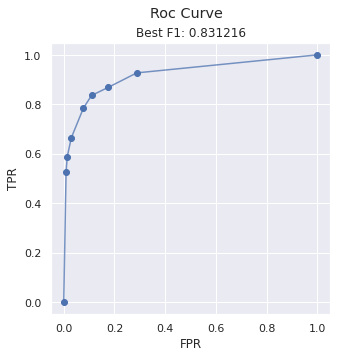

In [12]:
threshs = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
threshold = GetROCCurve(my_pipeline, X_train, y_train, threshs)

## Generating Predictions

<font size=3>Now that we have all of our parameters set up, we can use the whole dataset for training and finally **generate our predictions** to be submitted.

In [13]:
my_pipeline.fit(X, y, model__verbose=False)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=32.3671875,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1efb6a6990>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer...
                               importance_type=None, interaction_constraints='',
                      

In [14]:
preds = (my_pipeline.predict_proba(X_test)[:, 1] >= threshold) * 1
preds[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [15]:
my_submission = pd.DataFrame({'PassengerId': X_test.index, 'Survived': preds})
my_submission.to_csv('submission.csv', index=False)

In [16]:
my_submission.value_counts(subset='Survived')

Survived
0    332
1     86
dtype: int64